In [2]:
! pip install tensorflow

     |████████████████████████████████| 511.7 MB 19 kB/s s eta 0:00:01   |█▏                              | 18.3 MB 8.7 MB/s eta 0:00:57     |███████████████                 | 240.5 MB 58.3 MB/s eta 0:00:05
     |████████████████████████████████| 1.6 MB 77.2 MB/s eta 0:00:01
     |████████████████████████████████| 14.5 MB 77.4 MB/s eta 0:00:01
     |████████████████████████████████| 2.4 MB 74.5 MB/s eta 0:00:01
     |████████████████████████████████| 5.8 MB 39.1 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 5.2 MB/s  eta 0:00:01
     |████████████████████████████████| 75 kB 4.0 MB/s  eta 0:00:011
     |████████████████████████████████| 42 kB 1.1 MB/s  eta 0:00:01
     |████████████████████████████████| 438 kB 107.5 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 3.7 MB/s  eta 0:00:01
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4847 sha256=82e2df3200b1ec3d19d5b2bfef734b45127ee3abd5cb978948b69cf4cf90e9ec
  Stored in direct

In [67]:
# Import APIs
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from scipy.signal import resample
from sklearn.metrics import accuracy_score

# Control GPU consumption
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "True"

In [68]:
import os 

os.getcwd()
os.chdir('/opt/pytorch/')

In [69]:
import dataloaders
from dataloaders.bci_comp42a import BCIComp42aDataLoader

train_dataset = BCIComp42aDataLoader(data_path='/opt/pytorch/datasets/BCIComp42a',
                                     label_path='/opt/pytorch/datasets/BCIComp42a/true_labels',
                                     is_test=False,
                                     target_subject = 0, # subject #0 ~ #8
                                     s_freq=128, # 250 Hz -> 128 Hz
                                     l_freq=0, h_freq=38,
                                     t_min=-0.5, t_max=2.5)

test_dataset = BCIComp42aDataLoader(data_path='/opt/pytorch/datasets/BCIComp42a',
                                    label_path='/opt/pytorch/datasets/BCIComp42a/true_labels',
                                    is_test=True,
                                    target_subject = 0, # subject #0 ~ #8
                                    s_freq=128, # 250 Hz -> 128 Hz
                                    l_freq=0, h_freq=38,
                                    t_min=-0.5, t_max=2.5)


/opt/conda/lib/python3.7/site-packages/mne/io/edf/edf.py:1047: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/opt/pytorch/dataloaders/bci_comp42a.py:57: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_gdf(file_names, preload=True, eog=['EOG-left', 'EOG-central', 'EOG-right'], verbose=False)


Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Not setting metadata
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Loading data for 288 events and 385 original time points ...
0 bad epochs dropped


/opt/conda/lib/python3.7/site-packages/mne/io/edf/edf.py:1047: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/opt/pytorch/dataloaders/bci_comp42a.py:57: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_gdf(file_names, preload=True, eog=['EOG-left', 'EOG-central', 'EOG-right'], verbose=False)


Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
Not setting metadata
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Loading data for 288 events and 385 original time points ...
0 bad epochs dropped


In [70]:
import numpy as np

assert len(train_dataset) == len(test_dataset)

train_X = np.empty(shape=(len(train_dataset), train_dataset[0]['features'].shape[1], train_dataset[0]['features'].shape[2]),
                   dtype='float64')
train_y = np.empty(shape=(len(train_dataset)), dtype='int64')

test_X = np.empty(shape=(len(train_dataset), train_dataset[0]['features'].shape[1], train_dataset[0]['features'].shape[2]),
                  dtype='float64')
test_y = np.empty(shape=(len(train_dataset)), dtype='int64')

for i in range(len(train_dataset)):
    train_X[i] = train_dataset[i]['features']
    train_y[i] = train_dataset[i]['labels']
    
    test_X[i] = test_dataset[i]['features']
    test_y[i] = test_dataset[i]['labels']

train_X = np.expand_dims(train_X, axis=-1)
test_X = np.expand_dims(test_X, axis=-1)

num = np.unique(train_y, axis=0)
num = num.shape[0]

train_Y = np.eye(num)[train_y]
test_Y = np.eye(num)[test_y]

print(train_X.shape, test_X.shape) # (# trials, C, T, 1)
print(train_y.shape, test_y.shape) # (# trials, # classes)

(288, 22, 385, 1) (288, 22, 385, 1)
(288,) (288,)


In [75]:
# # Load dataset
# # I exploited Lee et al.'s, GigaScience, 2019.
# # The entire dataset is available at "https://github.com/namin-an/RL_BCI.git369."
# # path = 'Define/Your/Own/Path'
# train_X, train_Y = np.load(path + "train.npy"), np.load(path + "trlbl.npy")
# test_X, test_Y = np.load(path + "test.npy"), np.load(path + "tslbl.npy")

# # To check the size of data and label (C: # electrodes, T: # timepoints).
# print(train_X.shape, test_X.shape) # (C, T, # trials)
# print(train_Y.shape, test_Y.shape) # (# classes, # trials)

# # Select electrode channels on the sensorymotor area.
# ch_list = [7, 32, 8, 9, 33, 10, 34, 12, 35, 13, 36, 14, 37, 17, 38, 18, 39, 19, 40, 20]
# # We already conducted BPF (8~30Hz) and segments (0.5~3.5 sec).
# # Segments from 1 to 3.5-second (We used preprocessed data).
# train_X, test_X = train_X[ch_list, 500:, :], test_X[ch_list, 500:, :]
# # Downsample to 100Hz sampling rate.
# train_X = resample(train_X, int(train_X.shape[1] * 0.1), axis=1)
# test_X = resample(test_X, int(test_X.shape[1] * 0.1), axis=1)

# # Reshape the data.
# train_X = np.expand_dims(np.moveaxis(train_X, -1, 0), -1)
# test_X = np.expand_dims(np.moveaxis(test_X, -1, 0), -1)
# train_Y, test_Y = np.swapaxes(train_Y, 0, 1), np.swapaxes(test_Y, 0, 1)
# # To check the size.
# print(train_X.shape, test_X.shape) # (# trials, C, T, 1)
# print(train_Y.shape, test_Y.shape) # (# trials, # classes)

In [71]:
import tensorflow as tf

# Define a deep neural network-based BCI model.
# Here, we used Ko et al.'s, arXiv, 2020 (MSNN).
# For detail, see "https://arxiv.org/abs/2003.02657."
class MSNN(tf.keras.Model):
    tf.keras.backend.set_floatx("float64")
    def __init__(self):
        super(MSNN, self).__init__()
        self.C = 20
        self.fs = 100

        # Regularizer
        self.regularizer = tf.keras.regularizers.L1L2(l1=.001, l2=.01)

        # Activation functions
        self.activation = tf.keras.layers.LeakyReLU()
        self.softmax = tf.keras.layers.Softmax()
        
        # Define convolutions
        conv = lambda D, kernel : tf.keras.layers.Conv2D(D, kernel, kernel_regularizer=self.regularizer)
        sepconv = lambda D, kernel : tf.keras.layers.SeparableConv2D(D, kernel, padding="same",
                                                                    depthwise_regularizer=self.regularizer,
                                                                    pointwise_regularizer=self.regularizer)
        
        # Spectral convoltuion
        self.conv0 = conv(4, (1, int(self.fs/2)))
        
        # Spatio-temporal convolution
        self.conv1t = sepconv(16, (1, 25))
        self.conv1s = conv(16, (self.C, 1))
        
        self.conv2t = sepconv(32, (1, 15))
        self.conv2s = conv(32, (self.C, 1))
        
        self.conv3t = sepconv(64, (1, 6))
        self.conv3s = conv(64, (self.C, 1))

        # Flatteninig
        self.flatten = tf.keras.layers.Flatten()

        # Dropout
        self.dropout = tf.keras.layers.Dropout(0.5)

        # Decision making
        class_num = 4 # 2
        self.dense = tf.keras.layers.Dense(class_num, activation=None, kernel_regularizer=self.regularizer)

    def embedding(self, x, random_mask=False):
        x = self.activation(self.conv0(x))

        x = self.activation(self.conv1t(x))
        f1 = self.activation(self.conv1s(x))

        x = self.activation(self.conv2t(x))
        f2 = self.activation(self.conv2s(x))

        x = self.activation(self.conv3t(x))
        f3 = self.activation(self.conv3s(x))

        feature = tf.concat((f1, f2, f3), -1)
        return feature

    def classifier(self, feature):
        # Flattening, dropout, mapping into the decision nodes
        feature = self.flatten(feature)
        feature = self.dropout(feature)
        y_hat = self.softmax(self.dense(feature))
        return y_hat

    def GAP(self, feature):
        return tf.reduce_mean(feature, -2)

    def call(self, x):
        # Extract feature using MSNN encoder
        feature = self.embedding(x)
        # Global Average Pooling
        feature = self.GAP(feature)
        # Decision making
        y_hat = self.classifier(feature)
        return y_hat

In [72]:
# Define the informative segments selection agent module.
# Define actor network (for categorical actions: selection/rejection)
class ACTOR(tf.keras.Model):
    def __init__(self, n_actions=2):
        super().__init__()
        self.actor = tf.keras.layers.Dense(n_actions, activation=None, 
                                          kernel_regularizer=tf.keras.regularizers.L1L2(l1=.001, l2=.01))        
    def call(self, segment):
        return self.actor(segment) # Outputs logit vector.
    
# Define critic network
class CRITIC(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.critic = tf.keras.layers.Dense(1, activation=None,
                                           kernel_regularizer=tf.keras.regularizers.L1L2(l1=.001, l2=.01))
    def call(self, segment):
        return tf.keras.activations.sigmoid(self.critic(segment))

In [87]:
# Define utility functions.
def gradient(model, inputs, labels, mask=None):
    with tf.GradientTape() as tape:
        if mask is None:
            yhat = model(inputs)
        else:
            feature = model.GAP(model.embedding(inputs) * mask)
            yhat = model.classifier(feature)
        
        loss = tf.keras.losses.binary_crossentropy(labels, yhat)

    grad = tape.gradient(loss, model.trainable_variables)
    return loss, grad

def agent_gradient(model, actor, critic, inputs, feature, labels, state, state_next):
    gamma = 0.95 # discount factor
    with tf.GradientTape() as tape1, tf.GradientTape() as tape2:
        loss_FM = tf.keras.losses.binary_crossentropy(labels, model(inputs))      
        loss_AM = tf.keras.losses.binary_crossentropy(labels, model.classifier(feature))

        # Reward, r_t
        reward = loss_FM - loss_AM
        # Advantage, A_t
        advantage = reward[:, None] + gamma * critic(state_next) - critic(state)            
        # Critic loss
        critic_loss = 0.5 * tf.math.square(advantage)            
        # Actor loss
        actor_loss = -tf.math.log(tf.nn.softmax(actor(state))) * advantage

    critic_grad = tape1.gradient(critic_loss, critic.trainable_variables)
    actor_grad = tape2.gradient(actor_loss, actor.trainable_variables)
    
    qvalue = actor(state)
    qvalue = tf.reduce_max(qvalue, axis=[1])
    
    return critic_loss, critic_grad, actor_loss, actor_grad, reward, qvalue

In [88]:
import matplotlib.pyplot as plt

# Define experiment conducting class.
# Here, we trained and tested MSNN without the proposed agent module.
class experiment():
    def __init__(self, train_X, train_Y, test_X, test_Y):
        # Load dataset.
        # For simplicity, we just removed validating phase here.
        self.Xtr, self.Ytr = train_X, train_Y
        self.Xts, self.Yts = test_X, test_Y
        self.Yts = np.argmax(self.Yts, axis=-1) # To use scikit-learn accuracy function
        
        # Randomize the training dataset.
        rand_idx = np.random.permutation(self.Xtr.shape[0])
        self.Xtr, self.Ytr = self.Xtr[rand_idx, :, :, :], self.Ytr[rand_idx, :]

        # Learning schedules
        self.init_LR = 1e-3
        self.num_epochs_pre = 10 # Pre-training epochs
        self.num_epochs = 30
        self.num_batch = 20
        self.optimizer = tf.keras.optimizers.RMSprop(learning_rate=self.init_LR)
        
        # Here, we used subject 1's 2nd session data.
        self.sbj_idx, self.sess_idx = 1, 2
        print(f"START TRAINING Subject {self.sbj_idx}, Session {self.sess_idx}")
        
        # Call optimizer.
        self.num_batch_iter = int(self.Xtr.shape[0]/self.num_batch)
        
    def training_FM(self):
        # Call MSNN.
        msnn = MSNN()
        
        # To record the loss curve.
        loss_FM = []
        for epoch in range(self.num_epochs):
            loss_per_epoch = 0

            for batch in range(self.num_batch_iter):
                # Sample minibatch.
                xb = self.Xtr[batch * self.num_batch : (batch + 1) * self.num_batch, :, :, :]
                yb = self.Ytr[batch * self.num_batch : (batch + 1) * self.num_batch, :]

                # Estimate loss
                loss, grads = gradient(msnn, xb, yb)

                # Update the parameters
                self.optimizer.apply_gradients(zip(grads, msnn.trainable_variables))
#                 loss_FM.append(np.mean(loss))
                loss_per_epoch += np.mean(loss)

            loss_per_epoch /= self.num_batch_iter
            loss_FM.append(loss_per_epoch)
            
            # Reporting
            print(f"Iteration {epoch + 1}, Training Loss {loss_per_epoch:>.04f}")
            
        # Test the learned model.
        Yts_hat = np.argmax(msnn(test_X), axis=-1)
        print(f"\nSubject {self.sbj_idx}, Session {self.sess_idx},\
        Testing accuracy: {accuracy_score(self.Yts, Yts_hat)}!\n")
        return loss_FM
    
    def training_AM(self):
        # Call MSNN.
        msnn = MSNN()
        
        # To record the loss curve.
        loss_AM = []
        # Pre-training without the agent module
        for epoch in range(self.num_epochs_pre):
            loss_per_epoch = 0

            for batch in range(self.num_batch_iter):
                # Sample minibatch.
                xb = self.Xtr[batch * self.num_batch : (batch + 1) * self.num_batch, :, :, :]
                yb = self.Ytr[batch * self.num_batch : (batch + 1) * self.num_batch, :]

                # Estimate loss
                loss, grads = gradient(msnn, xb, yb)

                # Update the parameters
                self.optimizer.apply_gradients(zip(grads, msnn.trainable_variables))
                loss_AM.append(np.mean(loss))
                loss_per_epoch += np.mean(loss)

            loss_per_epoch /= self.num_batch_iter

            # Reporting
            print(f"Iteration {epoch + 1}, Training Loss {loss_per_epoch:>.04f}")
            
        # Call agent module.
        actor = ACTOR()
        critic = CRITIC()
        
        critic_loss_list, actor_loss_list = [], []
        reward_list, qvalue_list = [], []
        # Training with the agent module
        for epoch in range(self.num_epochs - self.num_epochs_pre):
            loss_per_epoch = 0
            critic_loss_per_epoch, actor_loss_per_epoch = 0, 0
            reward_per_epoch, qvalue_per_epoch = 0, 0
            
            for batch in range(self.num_batch_iter):
                print(f'EPOCH: {epoch}/{self.num_epochs - self.num_epochs_pre} BATCH: {batch}/{self.num_batch_iter}')
                # Sample minibatch.
                xb = self.Xtr[batch * self.num_batch : (batch + 1) * self.num_batch, :, :, :]
                yb = self.Ytr[batch * self.num_batch : (batch + 1) * self.num_batch, :]
                
                # Extract full segments.
                features = msnn.embedding(xb)
                              
                agg_wo_current = np.zeros((self.num_batch, features.shape[-1]))
                num_added = np.zeros((self.num_batch, features.shape[-1])) # To estimate the denominator.
                mask = np.zeros(features.shape) # Mask generated by the agent module
                for t in range(features.shape[-2] - 1): # t = 1,...,T'
                    deno1 = np.copy(num_added)
                    deno2 = np.copy(num_added) + 1 # For the features with the current segment.
                    # To avoid zero-division.
                    deno1[deno1 == 0] = 1.
                    
                    agg_w_current = agg_wo_current + features[:, 0, t, :]
                    
                    # Define state, s_t.
                    state = np.concatenate((agg_wo_current/deno1, agg_w_current/deno2), axis=-1)
                    # Get action, a_t.
                    action_probs = actor(state) 
                    action = np.tile(tf.random.categorical(action_probs, 1).numpy(), 112) # (5, 112)
                    mask[:, 0, t, :] = action
                    num_added += action
                    
                    # Current feature after action decision, phi_t.
                    deno3 = np.copy(num_added)
                    deno3[deno3 == 0] = 1 # To avoid zero-division.
                    feature = (agg_wo_current + features[:, 0, t, :] * action)/deno3
                    
                    # Define next state, s_{t+1}, temporally.
                    agg_wo_current = feature
                    tmp = agg_wo_current + features[:, 0, t + 1, :]
                    
                    state_next = np.concatenate((agg_wo_current/deno3, tmp/(deno3 + 1)), axis=-1)
                    
                    # Calculate critic and actor loss values
                    feature = np.expand_dims(feature, axis=1)
                    feature = np.concatenate((feature, feature, feature), axis=1)
                    critic_loss, critic_grads, actor_loss, actor_grads, reward, qvalue =\
                    agent_gradient(msnn, actor, critic, xb, feature, yb, state, state_next)
                    
                    critic_loss_per_epoch += np.mean(critic_loss)
                    actor_loss_per_epoch += np.mean(actor_loss)
                    reward_per_epoch += np.mean(reward)
                    qvalue_per_epoch += np.mean(qvalue)
                    
                    self.optimizer.apply_gradients(zip(critic_grads, critic.trainable_variables))
                    self.optimizer.apply_gradients(zip(actor_grads, actor.trainable_variables))
                                        
                # Finally, predict labels of input EEG using the selected segments.                
                # Update the parameters
                loss, grads = gradient(msnn, xb, yb, mask)
                self.optimizer.apply_gradients(zip(grads, msnn.trainable_variables))

                loss_per_epoch += np.mean(loss)                              

            loss_per_epoch /= self.num_batch_iter
            critic_loss_per_epoch /= (self.num_batch_iter*(features.shape[-2] - 1))
            actor_loss_per_epoch /= (self.num_batch_iter*(features.shape[-2] - 1))
            reward_per_epoch /= (self.num_batch_iter*(features.shape[-2] - 1))
            qvalue_per_epoch /= (self.num_batch_iter*(features.shape[-2] - 1))
            
            loss_AM.append(loss_per_epoch)
            critic_loss_list.append(critic_loss_per_epoch) 
            actor_loss_list.append(actor_loss_per_epoch)
            reward_list.append(reward_per_epoch) 
            qvalue_list.append(qvalue_per_epoch)
            
            plt.plot(np.arange(len(critic_loss_list)), np.array(critic_loss_list))
            plt.show()
            plt.plot(np.arange(len(actor_loss_list)), np.array(actor_loss_list))
            plt.show()
            plt.plot(np.arange(len(reward_list)), np.array(reward_list))
            plt.show()
            plt.plot(np.arange(len(qvalue_list)), np.array(qvalue_list))
            plt.show()
            
            # Reporting
            print(f"Iteration {epoch + 1 + self.num_epochs_pre}, Training Loss {loss_per_epoch:>.04f}")
            
        # Test the learned model.
        Yts_hat = np.argmax(msnn(test_X), axis=-1)
        print(f"\nSubject {self.sbj_idx}, Session {self.sess_idx}, \
        Testing accuracy: {accuracy_score(self.Yts, Yts_hat)}!\n")
        return loss_AM

In [90]:
exp = experiment(train_X, train_Y, test_X, test_Y)

START TRAINING Subject 1, Session 2


In [47]:
loss_FM = exp.training_FM()

Iteration 1, Training Loss 0.5656
Iteration 2, Training Loss 0.5633
Iteration 3, Training Loss 0.5630
Iteration 4, Training Loss 0.5625
Iteration 5, Training Loss 0.5603
Iteration 6, Training Loss 0.5530
Iteration 7, Training Loss 0.5376
Iteration 8, Training Loss 0.5170
Iteration 9, Training Loss 0.4968
Iteration 10, Training Loss 0.4794
Iteration 11, Training Loss 0.4650
Iteration 12, Training Loss 0.4534
Iteration 13, Training Loss 0.4439
Iteration 14, Training Loss 0.4361
Iteration 15, Training Loss 0.4294
Iteration 16, Training Loss 0.4234
Iteration 17, Training Loss 0.4178
Iteration 18, Training Loss 0.4125
Iteration 19, Training Loss 0.4073
Iteration 20, Training Loss 0.4023
Iteration 21, Training Loss 0.3973
Iteration 22, Training Loss 0.3923
Iteration 23, Training Loss 0.3874
Iteration 24, Training Loss 0.3827
Iteration 25, Training Loss 0.3782
Iteration 26, Training Loss 0.3736
Iteration 27, Training Loss 0.3693
Iteration 28, Training Loss 0.3650
Iteration 29, Training Loss 0

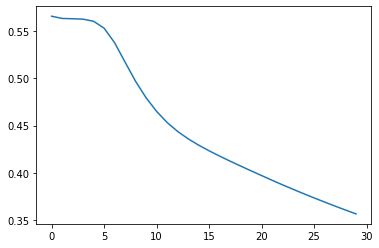

In [48]:
plt.plot(np.array(loss_FM))
plt.show()

In [ ]:
loss_AM = exp.training_AM()

Iteration 1, Training Loss 0.5637


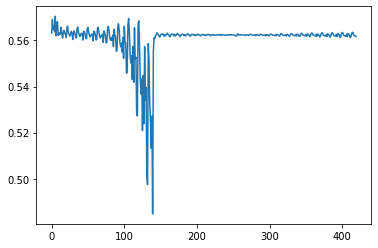

In [63]:
plt.plot(np.array(loss_AM))
plt.show()